In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import process_time

In [ ]:
#pip install lightgbm

In [2]:
# Training Data Loading - Sequential Sample of 5 Lakh rows 

t1_start = process_time()
train_df = pd.read_feather(r"C:\PC_Data\DBDA\Project\seq_train_data.ftr")
t1_stop = process_time()
print("Elapsed time for Loading Data in seconds:",t1_stop-t1_start)

Elapsed time for Loading Data in seconds: 2.9375


In [3]:
train_df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827


## Data Cleaning

In [4]:
# Converting the Numerical Columns to Categorical as per the original data set

cat_cols = ['D_63','D_64','D_66','D_68','B_30','B_38','D_114','D_116','D_117','D_120','D_126']

for col in cat_cols:
    train_df[col] = train_df[col].astype('category',copy=False)

In [5]:
train_df.shape

(500000, 190)

In [6]:
# Dropping the Columns with Null Values more than 70%

removed_cols=[]
for col in train_df.columns:
    if (train_df[col].isna().sum()/train_df.shape[0]*100) > 70 :
        removed_cols.append(col)
        train_df.drop(col, axis=1, inplace=True)

In [7]:
print(len(removed_cols))
print(removed_cols)

25
['D_42', 'D_49', 'D_53', 'D_66', 'D_73', 'D_76', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142']


In [8]:
train_df.shape

(500000, 165)

In [9]:
# Handling the missing Values 
# Imputing Categorical Columns with mode

for col in train_df.columns:
    if train_df[col].dtypes=='category':
        train_df[col] = train_df[col].fillna(train_df[col].mode()[0])

In [10]:
# Handling the missing Values 
# Imputing Numerical Columns with median

for col in train_df.columns:
    if train_df[col].dtypes=='float64':
        train_df[col] = train_df[col].fillna(train_df[col].median())

## Data Pre-processing

In [11]:
# Dummying the Categorical Columns

cat_cols=[]
for col in train_df.columns:
    if train_df[col].dtypes=='category':
        cat_cols.append(col)
        
train_df= pd.get_dummies(train_df, columns=cat_cols, drop_first=True)

In [12]:
train_df.shape

(500000, 188)

In [13]:
# Loading the Training Labels

t1_start = process_time()
labels = pd.read_csv(r"C:\PC_Data\DBDA\Project\train_labels.csv")
t1_stop = process_time()
print("Elapsed time for Loading Data in seconds:",t1_stop-t1_start)

Elapsed time for Loading Data in seconds: 0.34375


In [14]:
# Merging the Labels with Training Data

t1_start = process_time()
train_df = pd.merge(train_df, labels, on='customer_ID')
t1_stop = process_time()
print("Elapsed time for Merging Data in seconds:",t1_stop-t1_start)

Elapsed time for Merging Data in seconds: 0.1875


In [15]:
print(train_df['target'].value_counts()/len(train_df['target'])*100)

0    74.9978
1    25.0022
Name: target, dtype: float64


In [16]:
# The Data is highly imbalanced. Going ahead with a balancing technique.

In [17]:
# Splitting the training data into x_train and y_train

x_train = train_df.drop(['customer_ID','S_2','target'], axis=1)
y_train = train_df['target']

In [18]:
print(x_train.shape)
print(y_train.shape)

(500000, 186)
(500000,)


## Balancing the Training Data

In [19]:
# SMOTE Technique
from imblearn.over_sampling import SMOTE

smo = SMOTE(random_state=100)
x_resampled, y_resampled = smo.fit_resample(x_train, y_train)
print(np.unique(y_resampled,return_counts=True))

(array([0, 1], dtype=int64), array([374989, 374989], dtype=int64))


In [42]:
x_resampled.shape

(749978, 186)

In [68]:
x_resampled.info(max_cols=190)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 749978 entries, 0 to 749977
Data columns (total 186 columns):
 #    Column     Non-Null Count   Dtype  
---   ------     --------------   -----  
 0    P_2        749978 non-null  float64
 1    D_39       749978 non-null  float64
 2    B_1        749978 non-null  float64
 3    B_2        749978 non-null  float64
 4    R_1        749978 non-null  float64
 5    S_3        749978 non-null  float64
 6    D_41       749978 non-null  float64
 7    B_3        749978 non-null  float64
 8    D_43       749978 non-null  float64
 9    D_44       749978 non-null  float64
 10   B_4        749978 non-null  float64
 11   D_45       749978 non-null  float64
 12   B_5        749978 non-null  float64
 13   R_2        749978 non-null  float64
 14   D_46       749978 non-null  float64
 15   D_47       749978 non-null  float64
 16   D_48       749978 non-null  float64
 17   B_6        749978 non-null  float64
 18   B_7        749978 non-null  float64
 19   

In [20]:
del x_train, y_train

## Model Training 

In [21]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [22]:
# Parameter Tuning
params = {'boosting_type': ['gbdt'],
          'is_unbalance': [False],
          'max_bin': [900],
          'learning_rate': [0.05, 0.1],
          'max_depth': [9],
          'num_leaves' : [400], 
          'objective': ['binary']}

In [23]:
# Model Training 

kfold = StratifiedKFold(n_splits=5, shuffle=True ,random_state=100)
lgbm = LGBMClassifier()

gcv = GridSearchCV(lgbm,param_grid=params,scoring='roc_auc',cv=kfold, verbose=3)
gcv.fit(x_resampled, y_resampled)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END boosting_type=gbdt, is_unbalance=False, learning_rate=0.05, max_bin=900, max_depth=9, num_leaves=400, objective=binary;, score=0.974 total time=  58.9s
[CV 2/5] END boosting_type=gbdt, is_unbalance=False, learning_rate=0.05, max_bin=900, max_depth=9, num_leaves=400, objective=binary;, score=0.975 total time=  54.6s
[CV 3/5] END boosting_type=gbdt, is_unbalance=False, learning_rate=0.05, max_bin=900, max_depth=9, num_leaves=400, objective=binary;, score=0.973 total time=  53.4s
[CV 4/5] END boosting_type=gbdt, is_unbalance=False, learning_rate=0.05, max_bin=900, max_depth=9, num_leaves=400, objective=binary;, score=0.974 total time=  53.3s
[CV 5/5] END boosting_type=gbdt, is_unbalance=False, learning_rate=0.05, max_bin=900, max_depth=9, num_leaves=400, objective=binary;, score=0.974 total time= 1.1min
[CV 1/5] END boosting_type=gbdt, is_unbalance=False, learning_rate=0.1, max_bin=900, max_depth=9, num_leaves=400, o

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'boosting_type': ['gbdt'], 'is_unbalance': [False],
                         'learning_rate': [0.05, 0.1], 'max_bin': [900],
                         'max_depth': [9], 'num_leaves': [400],
                         'objective': ['binary']},
             scoring='roc_auc', verbose=3)

In [24]:
print(gcv.best_params_)
print(gcv.best_score_)

{'boosting_type': 'gbdt', 'is_unbalance': False, 'learning_rate': 0.1, 'max_bin': 900, 'max_depth': 9, 'num_leaves': 400, 'objective': 'binary'}
0.9797965487983722


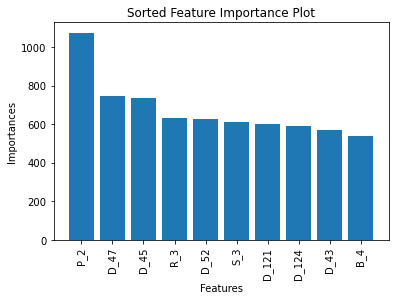

In [25]:
# Plotting a Feature Importance Plot

best_model = gcv.best_estimator_
#sorted Important Features Plot:
importances = best_model.feature_importances_
col_names = x_resampled.columns
neg_imp = -1*importances
i_desc_sorted = neg_imp.argsort()
imp_sorted = importances[i_desc_sorted][:10]
col_sorted = col_names[i_desc_sorted][:10]
plt.title('Sorted Feature Importance Plot')
plt.bar(col_sorted,imp_sorted)
plt.xticks(rotation=90)
plt.ylabel('Importances')
plt.xlabel('Features')
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams.update({'font.size': 12})
plt.show()

In [26]:
best_model = gcv.best_estimator_

## Best Score Achieved

### Params:

{'boosting_type': 'gbdt', 'is_unbalance': False, 'learning_rate': 0.1, 'max_bin': 900, 'max_depth': 9, 'num_leaves': 400, 'objective': 'binary'}

### ROC_AUC Score:
0.9797965487983722

## Validating the Model

In [163]:
# Loading the validation set

validation_df = pd.read_feather(r"C:\PC_Data\DBDA\Project\validation_set-1_last-100K.ftr")

In [164]:
validation_df.shape

(100000, 191)

In [188]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 5431451 to 5531450
Columns: 190 entries, customer_ID to D_126_1.0
dtypes: datetime64[ns](1), float16(153), int64(1), object(1), uint8(34)
memory usage: 34.7+ MB


### Data Cleaning

In [166]:
# Dropping the Columns with Null Values more than 70%, in line with Training Data

for col in removed_cols:
    validation_df.drop(col, axis=1, inplace=True)

In [167]:
validation_df.shape

(100000, 166)

In [168]:
# Handling the missing Values 
# Imputing Categorical Columns with mode

for col in validation_df.columns:
    if validation_df[col].dtypes=='category':
        validation_df[col] = validation_df[col].fillna(validation_df[col].mode()[0])

In [169]:
# Handling the missing Values 
# Imputing Numerical Columns with median

for col in validation_df.columns:
    if validation_df[col].dtypes=='float16':
        validation_df[col] = validation_df[col].fillna(validation_df[col].median())

### Data Pre-processing

In [170]:
# Dummying the Categorical Columns

cat_cols_val=[]
for col in validation_df.columns:
    if validation_df[col].dtypes=='category':
        cat_cols_val.append(col)
        
validation_df= pd.get_dummies(validation_df, columns=cat_cols_val, drop_first=True)

In [171]:
validation_df.shape

(100000, 190)

In [172]:
# Identifying the extra column
ex_col=[]
for col_1 in validation_df.columns:
    if col_1 not in x_resampled.columns:
        ex_col.append(col_1)

In [173]:
(ex_col)

['customer_ID', 'S_2', 'target', 'D_64_-1']

In [174]:
val_test = validation_df.drop(['customer_ID','S_2', 'target', 'D_64_-1'], axis=1)

In [175]:
val_test.shape

(100000, 186)

In [142]:
#del validation_df, val_test, val_result

### Predicting on Validation Set

In [176]:
val_result = best_model.predict(val_test)

In [177]:
val_result_prob = best_model.predict_proba(val_test)

In [178]:
comp_df = validation_df[['customer_ID','target']]

In [179]:
comp_df['prediction'] = val_result.tolist()

C:\Users\proje\AppData\Local\Temp\ipykernel_11628\3674168554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comp_df['prediction'] = val_result.tolist()


In [180]:
comp_df.head()

,customer_ID,target,prediction
5431451,fb6390864b705040850d5e4c19115c0ba665338679a4f0...,0,0
5431452,fb6390864b705040850d5e4c19115c0ba665338679a4f0...,0,0
5431453,fb6390864b705040850d5e4c19115c0ba665338679a4f0...,0,0
5431454,fb6390864b705040850d5e4c19115c0ba665338679a4f0...,0,0
5431455,fb6390864b705040850d5e4c19115c0ba665338679a4f0...,0,0


In [181]:
print(comp_df['target'].value_counts())
print(comp_df['prediction'].value_counts())

0    75062
1    24938
Name: target, dtype: int64
0    71771
1    28229
Name: prediction, dtype: int64


In [182]:
#y_true = comp_df['target']

In [183]:
import numpy as np

y_true = np.array(list(comp_df['target']))

In [184]:
val_result

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [185]:
from sklearn.metrics import classification_report

print(classification_report(y_true, val_result))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91     75062
           1       0.71      0.80      0.75     24938

    accuracy                           0.87    100000
   macro avg       0.82      0.85      0.83    100000
weighted avg       0.88      0.87      0.87    100000



In [186]:
from sklearn.metrics import confusion_matrix, log_loss

print(confusion_matrix(y_true, val_result))
print(log_loss(y_true, val_result_prob))

[[66815  8247]
 [ 4956 19982]]
0.28813973776028556


## Results achieved with LGBM, Balancing  - Validating with All Customer_IDs in Train Set:

              precision    recall  f1-score   support

           0       0.95      0.89      0.92    340085
           1       0.74      0.87      0.80    118828

    accuracy                           0.89    458913
   macro avg       0.84      0.88      0.86    458913
weighted avg       0.90      0.89      0.89    458913

### Confusion Matrix:

[[303037  37048]
 [ 14985 103843]]

### Log_Loss:
0.25137367581739917

 ## Results achieved with LGBM, Balancing - Validating with Last 100K obs in Train Set:


              precision    recall  f1-score   support

           0       0.93      0.89      0.91     75062
           1       0.71      0.80      0.75     24938

    accuracy                           0.87    100000
   macro avg       0.82      0.85      0.83    100000
weighted avg       0.88      0.87      0.87    100000

### Confusion Matrix:

[[66815  8247]
 [ 4956 19982]]

### Log_Loss:
0.28813973776028556